# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
from collections import Counter

data = pd.read_csv('datasets/real_estate_data.csv', sep='\t')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

Много столбцов содержат пропуски, в некоторых пропусков больше половины. Похоже пропускам бошье подвержена та часть, которую заполняют пользователи. Приступим к дальнейшему изучению данных.

### Шаг 2. Предобработка данных

In [2]:
# Сделаем ряд округлений
data['last_price'] = data['last_price'].astype('int')
# Преобразовываем в дату
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')

### rooms и studio

Посмотрим квартиры со сколькими комнатами самые распространенные:


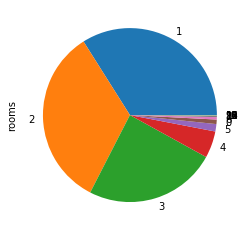

Самые популярные это от 1 до 4 комнат, однако есть и странности. 

Квартиры где 0 комнат: 197 

Из них студии: 138 

И в самих студиях где-то указано 0 комнат а где-то 1 

Для удобства будем считать что у студии всегда 0 комнат 

Теперь другая ситуация - площать квартир где 0 комнат, но это как бы не студии: 

count    208.000000
mean      29.179904
std       25.178794
min       15.500000
25%       24.037500
50%       26.075000
75%       28.600000
max      371.000000
Name: total_area, dtype: float64 

Если не считать выбросы, то площадь похожа на студию 

Если что-то выглядит как утка, крякает как утка, то это утка)


In [3]:
print('Посмотрим квартиры со сколькими комнатами самые распространенные:')
data['rooms'].value_counts().plot(kind='pie')
plt.show()
print('Самые популярные это от 1 до 4 комнат, однако есть и странности.','\n')
print('Квартиры где 0 комнат:',len(data[data['rooms'] == 0]),'\n')
print('Из них студии:', data[data['rooms'] == 0]['studio'].sum(),'\n')
print('И в самих студиях где-то указано 0 комнат а где-то 1','\n')
data[data['studio'] == True]['rooms'].value_counts()
print('Для удобства будем считать что у студии всегда 0 комнат','\n')
data.loc[data['studio'] == True,'rooms'] = 0
# А что с теми квартирами где указано 0 комнат, но флаг студия False?
print('Теперь другая ситуация - площать квартир где 0 комнат, но это как бы не студии:','\n')
print(data[data['rooms'] == 0]['total_area'].describe(),'\n')
print('Если не считать выбросы, то площадь похожа на студию','\n')
# Укажем что квартиры с 0 компат - это студии.
data.loc[data['rooms'] == 0,'studio'] = True
print('Если что-то выглядит как утка, крякает как утка, то это утка)')

### 'ceiling_height'
Имеем 9195 пропусков. Это почти половина датасета. При построении ящика с усами видим 782 выброса, это потолки ниже 2.25 м, и выше 3.25. Будем считать эти данные ошибкой ввода пользователя и обнулим их для дальнейшего заполнения. Все пропуски заполним медианой.

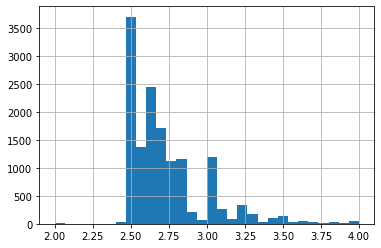

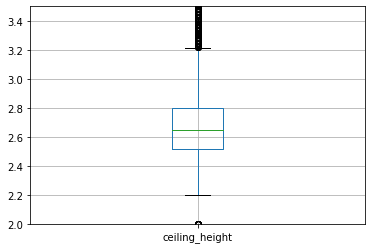

Всего выбросов: 782


In [4]:
# Построим гистограмму, что бы найти самые распространные варианты высоты полков
data['ceiling_height'].hist(bins=30, range=(2,4))
plt.show()
# Строим график ящик с усами
data.boxplot(column='ceiling_height')
# Ограничим ось для лучшей видимости результатов
plt.ylim((2,3.5))
plt.show()
# Считаем количество выбросов
print("Всего выбросов:", len(data.query('ceiling_height > 3.25 or ceiling_height < 2.25')))

# Обнуляем выбросы
data.loc[(data['ceiling_height']>3.25) | (data['ceiling_height']<2.25), 'ceiling_height'] = float('NaN')

# Считаем медиану
median_ceiling_height = data['ceiling_height'].median()

# Заполняем пропуски медианой
data['ceiling_height'] = data['ceiling_height'].fillna(median_ceiling_height)

### 'floors_total' 
Обрабатываем 86 пропусков. Так как не удалось найти взамосвязи этих пропусков с другими столбцами, предолагаю что пропуски возникли из-за того, что пользователь не ввел данную информацию. Есть два пути замены пропусков этажности дома. Первый подход - указать медиану. Второй подход -  оттолкнуться от популярности серии домов, т.е. самые популярные это пятиэтажные, на втором девятиэтажные и т.д. И если этаж не превышает пятый, считать пятиэтажкой и так дале. Так как количество пропусков небольшое - всего 0,4%, выберу подход с медианой, т.к. он проще.

Медианая этажность региона равна - 9 этажей


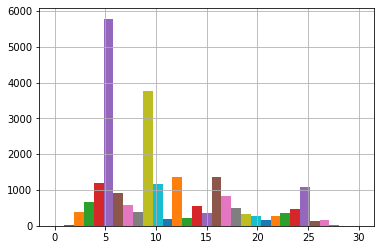

In [5]:
# Посмотрим какая этажность домов самая распрасраненная в регионе
data[data['floors_total'] < 35].groupby('floors_total')['floors_total'].hist(bins=31, range=(0,30))
# Считаем медиану
median_floors_total = data[data['floors_total'].notnull()]['floors_total'].median()
print('Медианая этажность региона равна - %r этажей'%int(median_floors_total))

def fill_flors_total(floor):
    """ Функция для заполнения пропусков этажности зданий медианой или в случае если этаж 
        продаваемой квартиры выше медианы, за этажность тогда примем этаж самой квартиры.
    """
    if floor < median_floors_total:
        return median_floors_total
    else:
        return floor
    
# Заполняем пропуски
data.loc[data['floors_total'].isnull(),'floors_total'] = data['floor'].apply(fill_flors_total)

# Этаж не может быть не целым числом
data['floors_total'] = data['floors_total'].astype('int')

Кто бы сомневался, самые популярные пятиэтажки и девятиэтажки. Получаем медиану - 9 этажей. Заполняем пропуски медианой, кроме тех случаев, где этаж самой квартиры выше девятого, там за этажность примем этаж продаваемой квартиры.

### living_area
Имеем 1903 пропуска. Мы посчитали, что средняя жилая площадь - это 54% от общей. Так и зполним пропуски.

In [6]:
print('Количество пропусков living_area:', data['living_area'].isna().sum())
print('Медиана living_area:', data['living_area'].median())
print('Медиана total_area:', data['total_area'].median())
# Посммотрим сколько примерное в процентах занимаем жилая площадь от общей
total_to_livin_ratio_by_median = data['living_area'].median() / data['total_area'].median()
print('Медиана к медиане:', total_to_livin_ratio_by_median)
total_to_livin_ratio_by_mean = data['living_area'].mean() / data[data['living_area'].isna()]['total_area'].mean()
print('Среднее к среднему:', total_to_livin_ratio_by_mean)
# Заполняем пропуски
data['living_area'] = data['living_area'].fillna(data['total_area'] * total_to_livin_ratio_by_mean)
# Округляем до целых значений
data['living_area'] = data['living_area'].astype('int')

Количество пропусков living_area: 1903
Медиана living_area: 30.0
Медиана total_area: 52.0
Медиана к медиане: 0.5769230769230769
Среднее к среднему: 0.5441876808779206


### 'is_apartment'
Здесь можно предположить что если это аппартаменты, то продавец отмечает это, а пропуски это вероятнее всего не апартаменты. Поэтому заполним пропуски значением False.

In [7]:
data['is_apartment'] = data['is_apartment'].fillna(False)

### kitchen_area
Площадь кухни, в отличии от жилой площади более менее фиксированная. Т.е. у квартиры с площадью 50 метров и 100, площадь кухним вполне может быть одинаковой. Поэтому пропуски заполним медианой.

In [8]:
kitchen_area_mediana = data[data['kitchen_area'].notna()]['kitchen_area'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_area_mediana)
# для удобства округлим площадь до целых
data['kitchen_area'] = data['kitchen_area'].astype('int')

### 'balcony'
Имеем 11519 пропусков. Согласно гистограммам ниже, видим что вероятность наличия балкона на первом этаже невысокая, а со второго и выше уже ближе к медиане, которая равна 1. Так и заполним пропуски 0 для первого этажа, медиана для остальных.

Пропусков balcony 11519


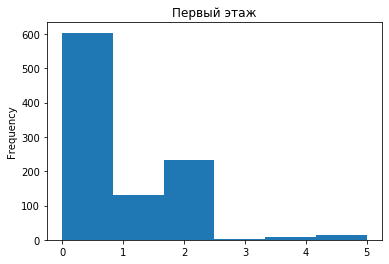

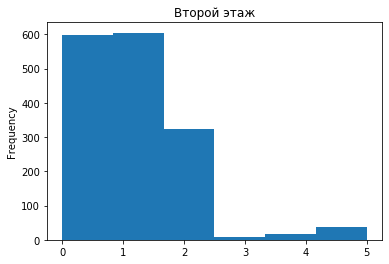

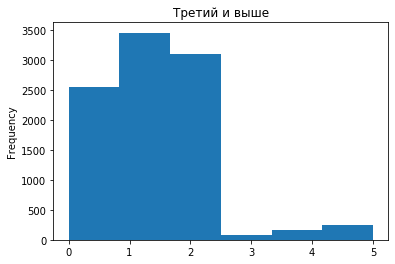

In [9]:
# Считаем количество пропусков
print('Пропусков balcony',data['balcony'].isna().sum())

# Считаем медиану
median_balcony = data['balcony'].median()

# Смотрим вероятность наличия балкона в зависимости от этажа.
data[data['floor'] == 1]['balcony'].plot(kind='hist',bins=6, title='Первый этаж')
plt.show()
data[data['floor'] == 2]['balcony'].plot(kind='hist',bins=6, title='Второй этаж')
plt.show()
data[data['floor'] > 2]['balcony'].plot(kind='hist',bins=6, title='Третий и выше')
plt.show()

# Заполняем пропуски
def fill_balccony(floor):
    if floor < 2:
        return 0
    else:
        return 1
    
data.loc[data['balcony'].isnull(), 'balcony'] = data['floor'].apply(fill_balccony)
data['balcony'] = data['balcony'].astype('int')

### locality_name
Всего 49 пропусков, и как их заполнить непонятно. Идалим их. Т.к. это поле заполнялось автоматически то здесь проблема была либо при заполнении, либо при выгрузке данных.
Оставшиеся значения сгруппируем.

Всего пропусков в locality_name: 49
Сгруппированные данные по населенному понкту:


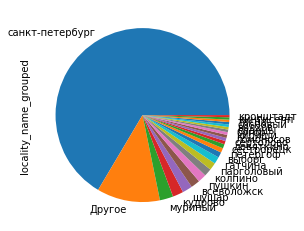

In [10]:
print('Всего пропусков в locality_name:',data['locality_name'].isna().sum())
data = data.dropna(subset=['locality_name'])
stemmer = Mystem()
locality_name_str =' '.join(data['locality_name'])
locality_name_lst = Counter(stemmer.lemmatize(locality_name_str)).most_common()
locality_name_grouped = {'санкт-петербург', 'муриный', 'кудрово', 'шушар', 'всеволожск', 
                         'пушкин', 'колпино', 'парголовый', 'гатчина', 'выборг', 'петергоф', 
                         'сестрорецк', 'девяткино', 'сертолово', 'ломоносов', 'бугор', 
                         'сланцы', 'волхов', 'кириши', 'сосновый', 'кингисепп', 'тосно', 
                         'кронштадт'}

def fill_locality_name(locality_name):
    """ Функция для группировки населенного пункта.
    """
    name_lst = stemmer.lemmatize(locality_name)
    for word in name_lst:
        if word in locality_name_grouped:
            return word
        
    return 'Другое'
    
data['locality_name_grouped'] = data['locality_name'].apply(fill_locality_name)
print('Сгруппированные данные по населенному понкту:')
data['locality_name_grouped'].value_counts().plot(kind='pie')

### days_exposition
Мы видим, что поле пустое преимущественно для квартир, размещенных в последний отрезок времени, из чего можно сделать вывод, что эти квартиры еще не проданы, поэтому поле пустое. Уберем эти квартиры из выборки.


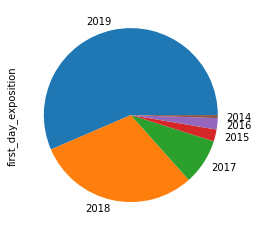

In [11]:
data[data['days_exposition'].isna()]['first_day_exposition'].dt.year.value_counts().plot(kind='pie')
plt.show()
data = data.dropna(subset=['days_exposition'])

### 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000','ponds_nearest'
по этим автоматически заполненным полям, очень много пропусков - порядка 5 тысяч. Не хотелось бы заполнять их средними или медианами, т.к. такое количество усреднений может повлиять на статистику. Пока оставлю их незаполненными, но что бы извавиться от NaN укажу в них -1.

Гистограмма для столбца: airports_nearest


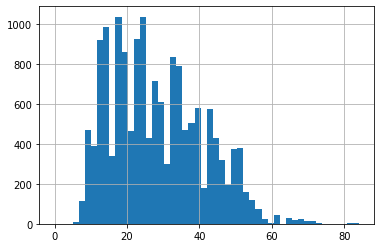

Гистограмма для столбца: cityCenters_nearest


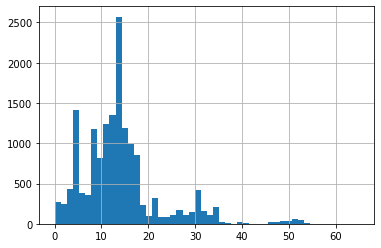

Гистограмма для столбца: parks_around3000


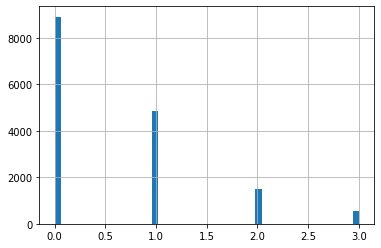

Гистограмма для столбца: parks_nearest


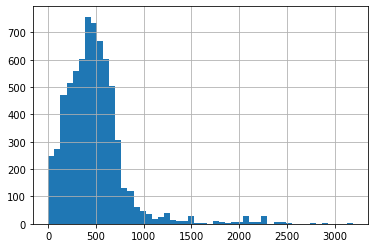

Гистограмма для столбца: ponds_around3000


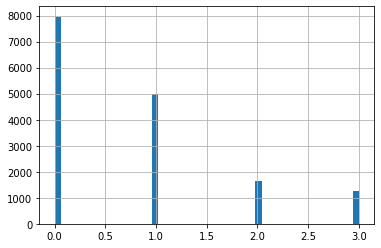

Гистограмма для столбца: ponds_nearest


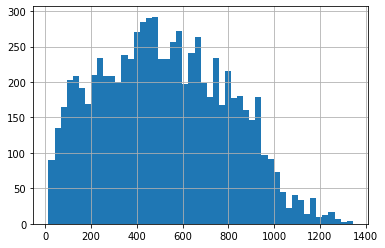

In [12]:
# Колонки с автозаполнением
columns = ['airports_nearest', 'cityCenters_nearest',
           'parks_around3000', 'parks_nearest', 'ponds_around3000',
           'ponds_nearest']
# Значения в метрах, которые нужно перевести в километры
to_kilometers = ['airports_nearest', 'cityCenters_nearest']
for column in columns:
    # Заполним пропуски значением -1
    data[column] = data[column].fillna(-1)
    # Округлим до километров
    if column in to_kilometers:
        data.loc[data[column] != -1, column] = data[column] / 1000
        data[column] = data[column].astype('int')
    print('Гистограмма для столбца:',column)
    data[data[column] != -1][column].hist(bins=50)
    plt.show()

### Шаг 3. Посчитайте и добавьте в таблицу

In [13]:
# Считаем цену квадратного метра
data['price_for_meter'] = data['last_price'] / data['total_area']

# Сгруппируем этаж квартиры
def floor_group(row):
    if row['floor'] == 1:
        return 'Первый'
    elif row['floor'] == row['floors_total']:
        return 'Последний'
    else:
        return 'Другое'

data['floor_type'] = data.apply(floor_group, axis=1)

# Добавляяем соотношение жилой к общей площади и кухни к общей площади
data['living_to_total_area'] = data['living_area'] / data['total_area']
data['kitchen_to_total_area'] = data['kitchen_area'] / data['total_area']

# Добавим год, месяц и день недели, когда квартира была выставлена на продажу
data['year'] = data['first_day_exposition'].dt.year
data['month'] = data['first_day_exposition'].dt.month
data['weekday'] = data['first_day_exposition'].dt.weekday

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### total_area


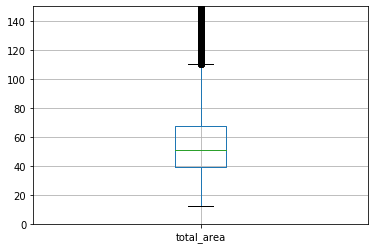

Считаем количество выбросов: 1028


In [14]:
# Построим ящик с усами и найдем выбросы
data.boxplot(column=['total_area'])
plt.ylim(0,150)
plt.show()
print('Считаем количество выбросов:',len(data.query('total_area > 110')))

### days_exposition

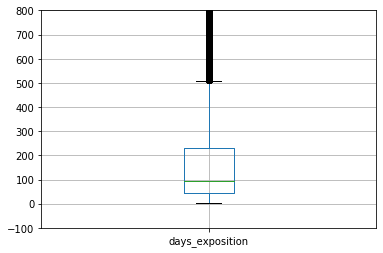

Считаем количество выбросов: 1744
Среднее время продажи - 180
Медианное время продажи - 95


In [15]:
# Построим ящик с усами и найдем выбросы
data.boxplot(column='days_exposition')
plt.ylim(-100, 800)
plt.show()
print('Считаем количество выбросов:',len(data.query('days_exposition > 500')))
print('Среднее время продажи -', int(data['days_exposition'].mean()))
print('Медианное время продажи -', int(data['days_exposition'].median()))

### Вывод
Средняя в два раза больше медианы. Вот что делают аномально большие значения в выбросах. Получается что обычная квартира продается за три месяца.

### last_price

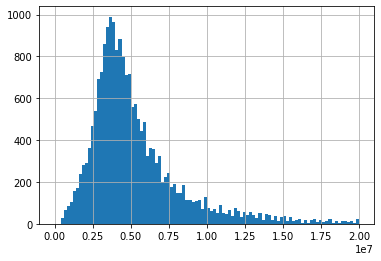

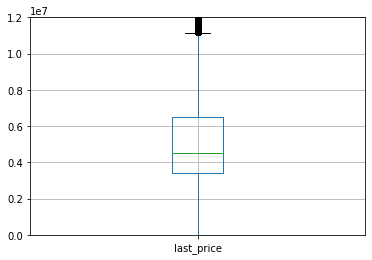

Считаем количество выбросов: 2034


In [16]:
# Построим ящик с усами и найдем выбросы
data['last_price'].hist(bins=100, range=(0,20000000))
plt.show()
data.boxplot(column='last_price')
plt.ylim(0,12000000)
plt.show()
print('Считаем количество выбросов:',len(data.query('last_price > 10000000')))

In [17]:
# Данные без выбросов
good_data = data.query('total_area <= 110 and days_exposition <= 500 and last_price <= 10000000')

### price_for_meter
Цена за квадратный метр без выбросов выглядит очень красиво, почти идеальное нормальное распределение.

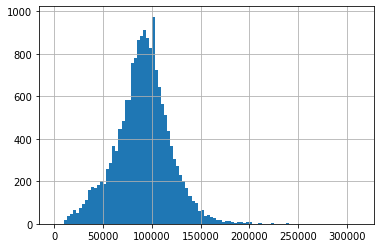

In [18]:
good_data['price_for_meter'].hist(bins=100)
plt.show()

### Сравним время продажи квартиры до удаления выбросов и после

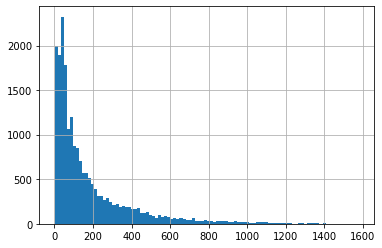

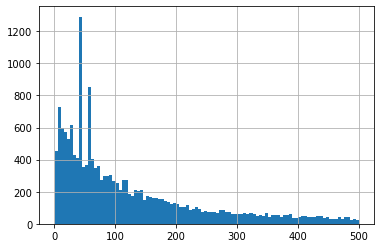

count    16943.000000
mean       123.348817
std        117.499655
min          1.000000
25%         39.000000
50%         79.000000
75%        176.000000
max        500.000000
Name: days_exposition, dtype: float64

In [19]:
data['days_exposition'].hist(bins=100)
plt.show()
good_data['days_exposition'].hist(bins=100)
plt.show()
good_data['days_exposition'].describe()

### Выводы
После очистки от выбросов, медиана и средняя по сроку продажи квартиры приблизились друг к другу. Теперь более понятно, что быстрая продажа квартиры это до 40 дней, а относительно долгая это более полугода. А обычно квартира продается за 2,5 месяца. Еще мы видим на графике два странных прика, это 45 дней и 60 дней, возможно это какие-то особенности самого сайта, например через 45 дней объявление уходит из выдачи поисковика, или заканчивается переиод размещения если его не продлить.

## От чего зависит цена квартиры?

In [20]:
good_data.corr().sort_values('last_price', ascending=False)['last_price']

last_price               1.000000
total_area               0.671301
price_for_meter          0.605071
living_area              0.546047
rooms                    0.426258
kitchen_area             0.408159
ponds_around3000         0.402150
parks_around3000         0.400093
airports_nearest         0.350100
ceiling_height           0.297727
parks_nearest            0.215211
floors_total             0.212684
ponds_nearest            0.203791
total_images             0.159335
floor                    0.144006
cityCenters_nearest      0.142734
balcony                  0.111593
days_exposition          0.033560
living_to_total_area     0.030278
is_apartment             0.016969
year                     0.009667
month                    0.004702
weekday                 -0.006717
open_plan               -0.053570
studio                  -0.093035
kitchen_to_total_area   -0.182534
Name: last_price, dtype: float64

In [21]:
not_digit_columns = ['locality_name_grouped', 'floor_type']
for column in not_digit_columns:
    pvt = good_data.pivot_table(index=column, values='last_price', 
                                aggfunc=['count','median'])
    pvt.columns = ['count', 'median_price']
    print(pvt.sort_values('median_price', ascending=False))

                       count  median_price
locality_name_grouped                     
сестрорецк               129       5100000
санкт-петербург        10733       4899000
пушкин                   255       4700000
парголовый               286       4045000
шушар                    382       3915000
кудрово                  402       3815000
петергоф                 154       3594500
кронштадт                 79       3590000
колпино                  290       3560000
девяткино                114       3549500
бугор                     97       3400000
муриный                  517       3358000
всеволожск               304       3350000
сосновый                  80       3300000
сертолово                108       3275000
ломоносов                 94       3190000
гатчина                  241       3050000
тосно                     87       2900000
выборг                   189       2750000
Другое                  2059       2400000
кингисепп                 90       2300000
кириши     

### Выводы
Основные параметры, влияющие на цену, в целом предсказуемы: площадь, цена за метр, количество комнат, высота потолка. Первый и последний этажи стоят дешевле остальных.

Так же есть ряд важных параметров, которые были не так очевидны - это наличие рядом парка или пруда, близость к аэропорту. Ну и пришлось погуглить что же такое Сестрорецк, квартиры в котором дороже чем в Питере) Это оказалалсь курортная часть тогоже Питера. 

### Средняя цена за квадратный метр в зависимости от населенного пункта

In [22]:
for column in ['locality_name_grouped','locality_name']:
    pvt = good_data.pivot_table(index=column, values='price_for_meter', 
                                    aggfunc=['count','mean'])
    pvt.columns = ['count', 'mean_price_for_meter']
    print(pvt.sort_values('count', ascending=False)[:10], '\n')

                       count  mean_price_for_meter
locality_name_grouped                             
санкт-петербург        10733         103531.022318
Другое                  2059          53461.763770
муриный                  517          85983.765190
кудрово                  402          94516.855748
шушар                    382          77964.172000
всеволожск               304          66579.535635
колпино                  290          74538.679670
парголовый               286          89360.980969
пушкин                   255          98990.490340
гатчина                  241          68275.333827 

                   count  mean_price_for_meter
locality_name                                 
Санкт-Петербург    10733         103531.022318
посёлок Мурино       485          86070.054278
посёлок Шушары       382          77964.172000
Всеволожск           304          66579.535635
Колпино              290          74538.679670
посёлок Парголово    286          89360.980969
деревня Ку

### Вывод
В Санкт-Петербурге цена квадратного метра выше, но в некоторых соседних городах цена вполне сравнима.

### Изменение цены в зависимости от удаленности от центра.

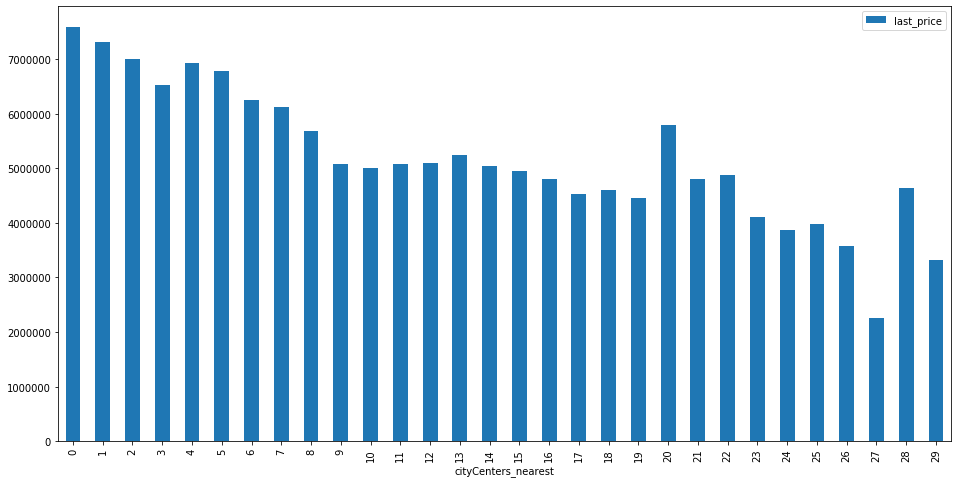

In [23]:
piter_data = good_data.query(
    'locality_name_grouped == "санкт-петербург" and cityCenters_nearest != -1')
pvt = piter_data.pivot_table(index='cityCenters_nearest', values='last_price',
                             aggfunc='mean')
pvt.plot(kind='bar', figsize=(16,8))
plt.show()

### Вывод
На графике можно увидеть что в пределах 5 километров от центра (часе ходьбы), квартиры стоят в среднем 7 миллионов и выше. Дальше цена начинает постепенно падать и в отдаленных районах стоит в срденем порядка 2 миллионов.

### Проанализируем центр города в сравнении со всем городом

In [24]:
piter_data_corr = piter_data.corr().sort_values('last_price', ascending=False)['last_price']
piter_center_data = piter_data.query('cityCenters_nearest <= 5')
piter_center_data_corr = piter_center_data.corr().sort_values('last_price', ascending=False)['last_price']
piter_compare = pd.concat([piter_data_corr, piter_center_data_corr], axis=1,sort=False) 
piter_compare.columns = ['piter_data','piter_center_data']
piter_compare['diff'] = piter_compare['piter_center_data'] - piter_compare['piter_data']
piter_compare.sort_values('diff', ascending=False)

,piter_data,piter_center_data,diff
cityCenters_nearest,-0.320910,-0.064060,0.256850
floor,0.064210,0.159385,0.095175
days_exposition,0.080561,0.138754,0.058193
weekday,0.006547,0.041405,0.034858
airports_nearest,0.001863,0.027074,0.025212
year,0.029399,0.034636,0.005237
balcony,0.113194,0.116401,0.003207
last_price,1.000000,1.000000,0.000000
parks_around3000,0.100278,0.092128,-0.008150
is_apartment,0.005713,-0.009427,-0.015139


total_area piter_data vs piter_center_data
Медиана равна - 48.0


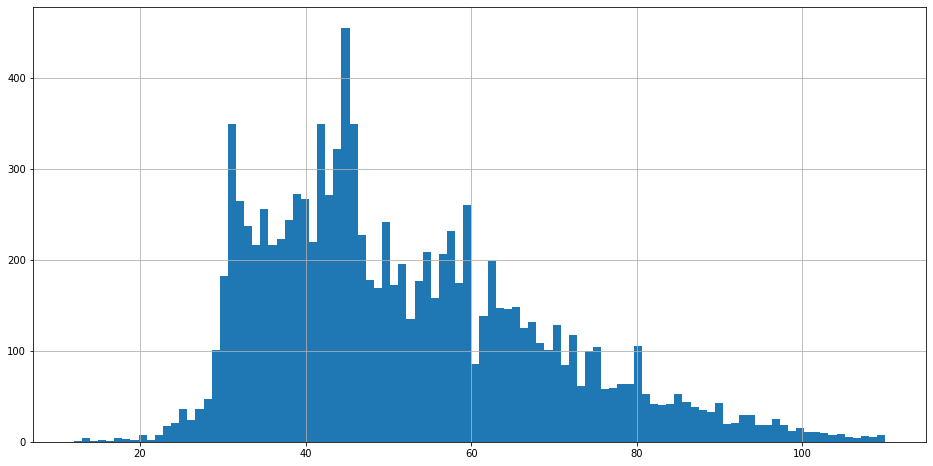

Медиана равна - 61.0


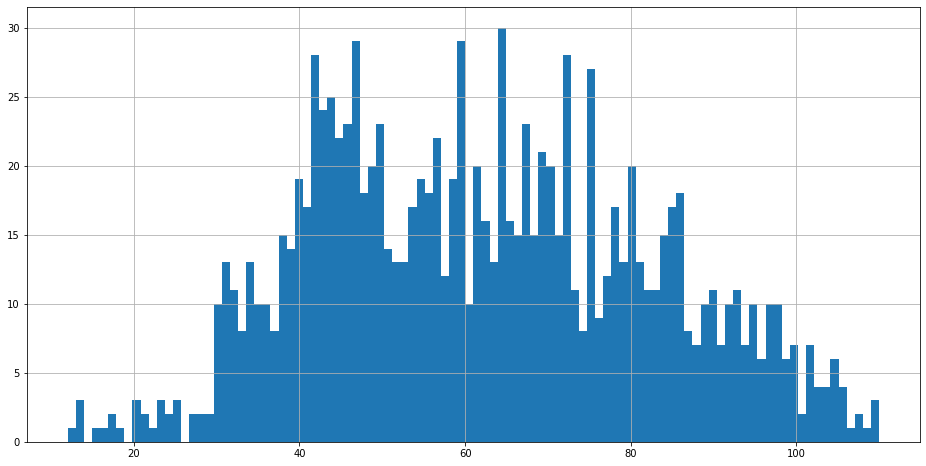

last_price piter_data vs piter_center_data
Медиана равна - 4899000.0


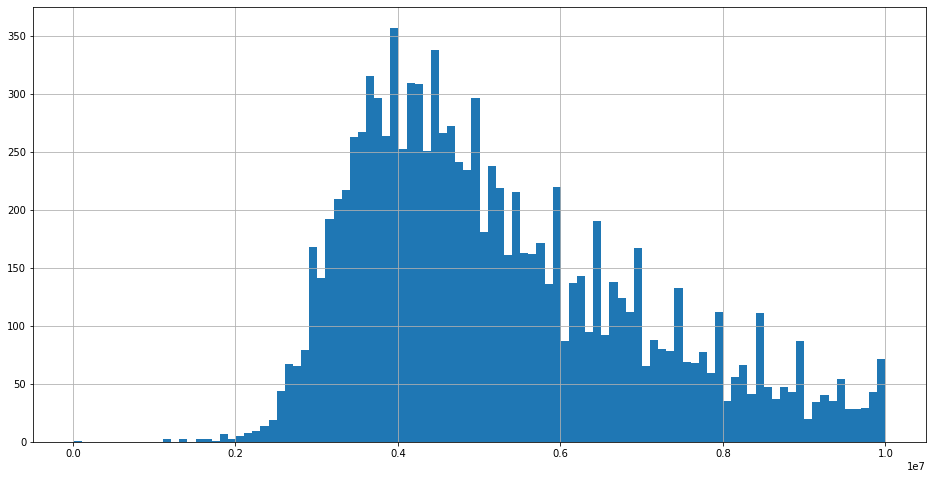

Медиана равна - 6900000.0


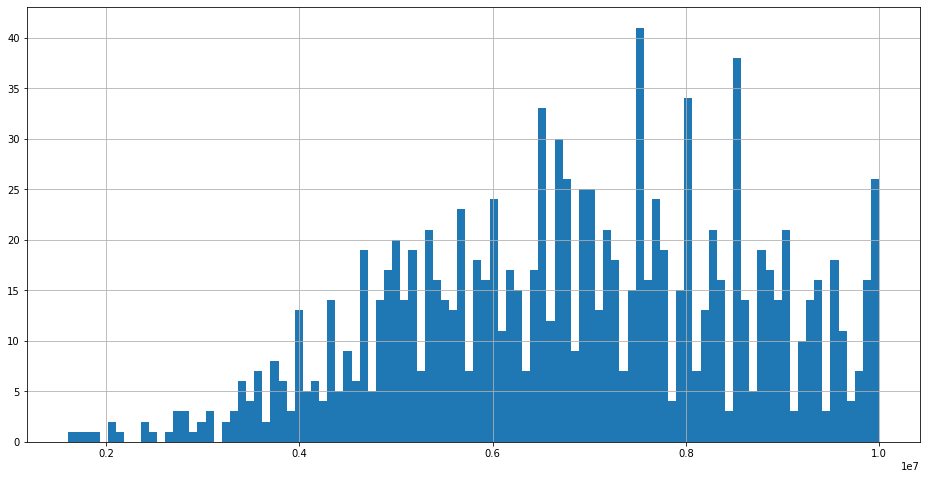

rooms piter_data vs piter_center_data
Медиана равна - 2.0


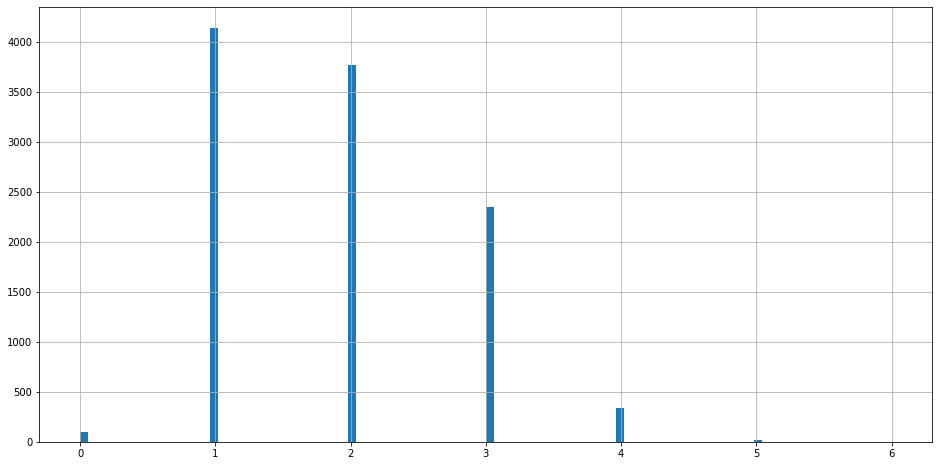

Медиана равна - 2.0


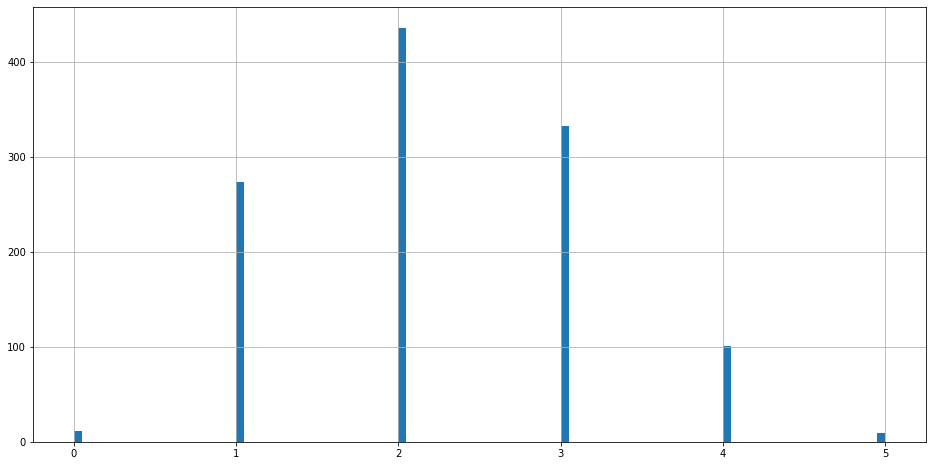

ceiling_height piter_data vs piter_center_data
Медиана равна - 2.64


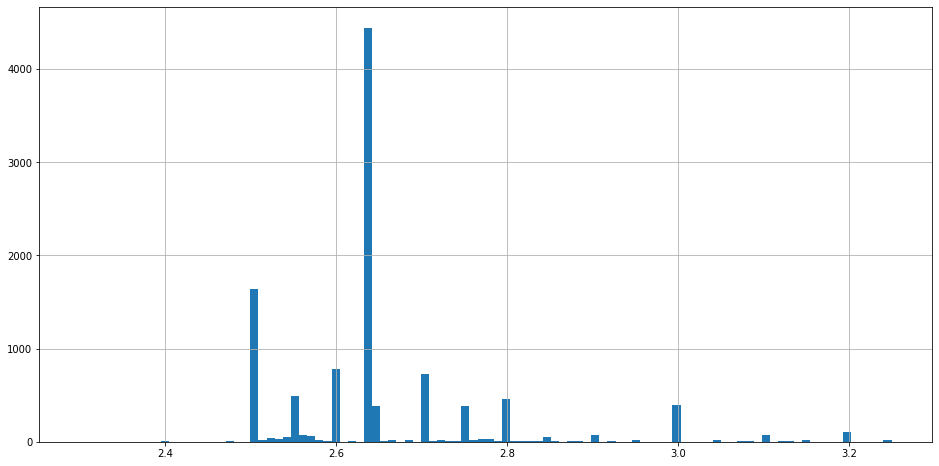

Медиана равна - 2.64


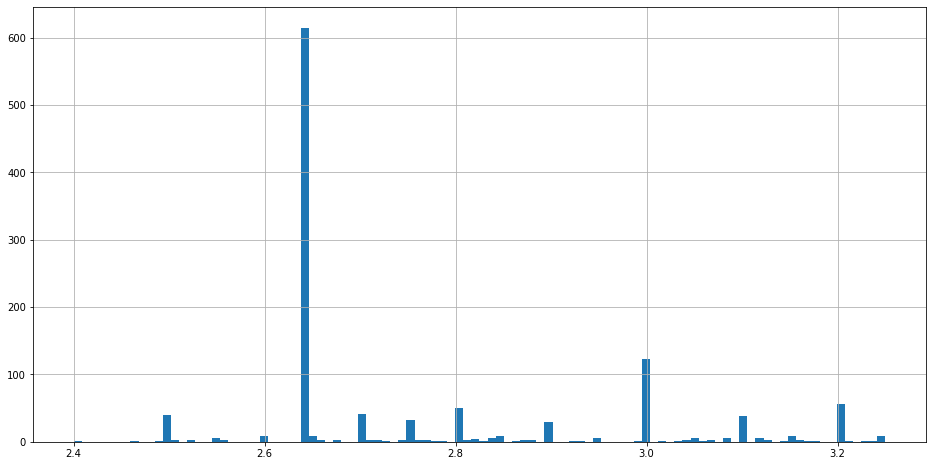

In [25]:
columns_for_compare = ['total_area', 'last_price', 'rooms', 'ceiling_height']
for column in columns_for_compare:
    print(column, 'piter_data vs piter_center_data')
    for dataset in [piter_data, piter_center_data]:
        print('Медиана равна -', dataset[column].median())
        dataset[column].hist(bins=100, figsize=(16,8))
        plt.show()

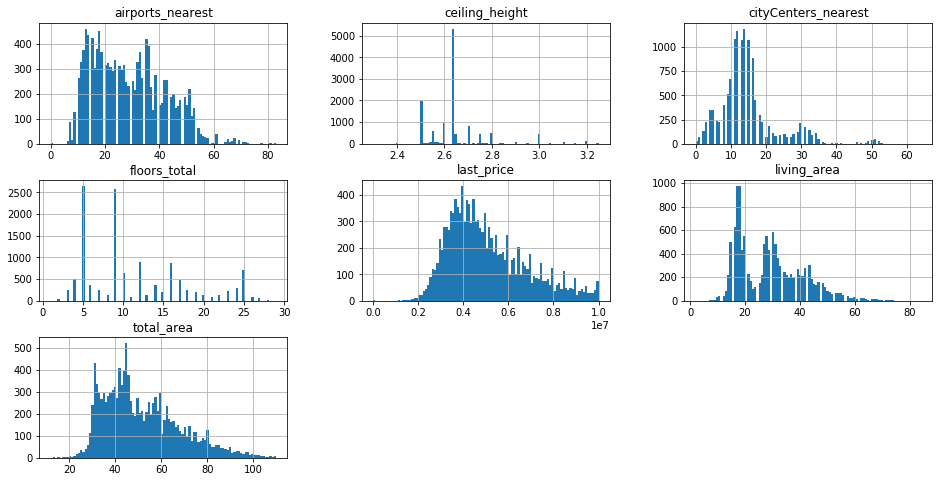

In [37]:
good_data.loc[
    (good_data['airports_nearest'] != -1) & (good_data['floors_total'] < 30), 
    ['last_price', 'total_area', 'ceiling_height', 'floors_total', 'living_area', 'airports_nearest', 'cityCenters_nearest']
].hist(bins=100, figsize=(16,8))
plt.show()

### Выводы
В центре Санкт-Петербурга мы видим что средняя площадь квартир больше, средняя цена квартиры выше. 
Если брать весь город, то самая популярная это однокомнатная квартира, в центра - двухкомнатная. А вот высота потолков отличается не сильно.

Что касается сравнения кореляции с другими параметрами, то можно сказать что в центре города на цену влияют почти те же самы параменты, отклонения не значительные.

### Шаг 5. Общий вывод

Основные параметры, влияющие на цену, в целом предсказуемы: площадь, цена за метр, количество комнат, высота потолка. Первый и последний этажи стоят дешевле остальных.
Так же есть ряд важных параметров, которые были не так очевидны - это наличие рядом парка или пруда, близость к аэропорту.
В Питере цены выше чем за пределами города.
В центре города квартиры дороже, средняя площадь больше.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод